# Part 6: Predicting Sales

Up to this point, almost all our prediction models were on customer level (e.g. churn prediction, next purchase day, etc.). It is useful to zoom out and look at the broader picture as well. By considering all our efforts on the customer side, how do we affect the sales?

Time series forecasting is one of the major building blocks of Machine Learning. There are many methods in the literature to achieve this like:
* Autoregressive Integrated Moving Average (ARIMA), 
* Seasonal Autoregressive Integrated Moving-Average (SARIMA), 
* Vector Autoregression (VAR), and so on.

In this notebook, we will focus on **Long Short-term Memory** (LSTM) method, which is a quite popular one if you want to use Deep Learning. We will use [Keras](https://keras.io/) in our project to implement LSTM.


### How does knowing the future sales helps our business?
1. First of all, it is a __benchmark__. We can use it as the business as usual level we are going to achieve if nothing changes in our strategy. Moreover, we can calculate the incremental value of our new actions on top of this benchmark.
1. Second, it can be utilized for __planning__. We can plan our demand and supply actions by looking at the forecasts. It helps to see where to invest more.
1. Last but not least, it is an excellent __guide__ for planning budgets and targets.


Work in this notebook is divided into 3 steps:
* Data Wrangling
* Data Transformation to make it stationary and supervised
* Building the LSTM model & evaluation

## Data Wrangling
In this example, we use the dataset from a Kaggle competition. It represents the daily sales for each store and item.
* date - Date of the sale data. There are no holiday effects or store closures.
* store - Store ID
* item - Item ID
* sales - Number of items sold at a particular store on a particular date.

In [1]:
# import libraries
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np
import seaborn as sns
%matplotlib inline

#do not show warnings
import warnings
warnings.filterwarnings("ignore")

In [2]:
#import machine learning related libraries
import keras
from keras.layers import Dense
from keras.models import Sequential
from keras.optimizers import Adam 
from keras.callbacks import EarlyStopping
from keras.utils import np_utils
from keras.layers import LSTM
from sklearn.model_selection import cross_val_score, train_test_split

Using TensorFlow backend.


In [3]:
#read the data in csv
df_sales = pd.read_csv('data/sales-train.csv', parse_dates=['date'])

#show first 10 rows
df_sales.head(10)

,date,store,item,sales
0,2013-01-01,1,1,13
1,2013-01-02,1,1,11
2,2013-01-03,1,1,14
3,2013-01-04,1,1,13
4,2013-01-05,1,1,10
5,2013-01-06,1,1,12
6,2013-01-07,1,1,10
7,2013-01-08,1,1,9
8,2013-01-09,1,1,12
9,2013-01-10,1,1,9


In [4]:
df_sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 913000 entries, 0 to 912999
Data columns (total 4 columns):
date     913000 non-null datetime64[ns]
store    913000 non-null int64
item     913000 non-null int64
sales    913000 non-null int64
dtypes: datetime64[ns](1), int64(3)
memory usage: 27.9 MB


Our task is to forecast monthly total sales. We need to aggregate our data at the monthly level and sum up the sales column.

In [5]:
#groupby on first of month (MS) and sum the sales
df_M_sales = df_sales.groupby(pd.Grouper(key='date', freq='MS'))['sales'].sum().reset_index()
df_M_sales.head()

,date,sales
0,2013-01-01,454904
1,2013-02-01,459417
2,2013-03-01,617382
3,2013-04-01,682274
4,2013-05-01,763242


## Data Transformation
To model our forecast easier and more accurate, we will do the transformations below:
* convert the data to stationary if it is not
* convert from time series to supervised for having the feature set of our LSTM model
* scale the data

First off, how do we check if the data is stationary? Let’s plot it and see:

[Text(0.5, 1, 'Monthly Sales')]

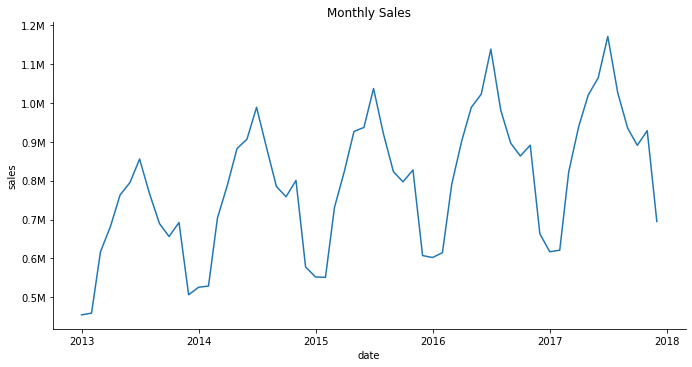

In [6]:
# plot monthly sales
g = sns.relplot(x='date', y='sales', kind='line', aspect=2, data=df_M_sales)

# format x-axis in Millions
g.ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: '{:,.1f}'.format(x/1000000) + 'M'))
g.ax.set(title='Monthly Sales')

Obviously, it is not stationary and has an increasing trend over the months. One method is to get the difference in sales compared to the previous month and build the model on it:

In [7]:
# create a new dataframe to model the difference
df_diff = df_M_sales.copy()

# add previous sales to the next row
df_diff['prev_sales'] = df_diff['sales'].shift(1)

# drop the null values and calculate the difference
df_diff = df_diff.dropna()
df_diff['diff'] = (df_diff['sales'] - df_diff['prev_sales'])

Now we have the required dataframe for modeling the difference. Let’s plot it and check if it is stationary now:

In [8]:
df_diff.head()

,date,sales,prev_sales,diff
1,2013-02-01,459417,454904.0,4513.0
2,2013-03-01,617382,459417.0,157965.0
3,2013-04-01,682274,617382.0,64892.0
4,2013-05-01,763242,682274.0,80968.0
5,2013-06-01,795597,763242.0,32355.0


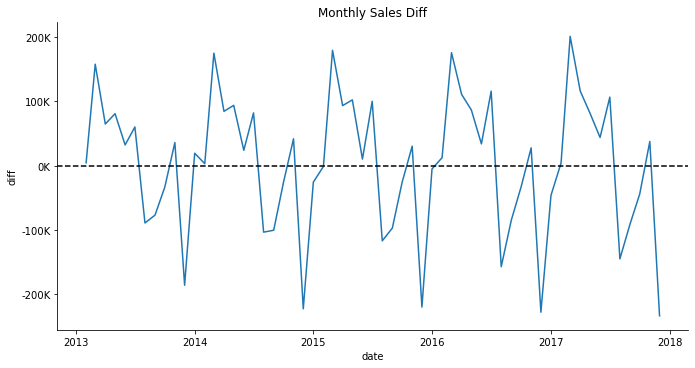

In [9]:
#plot sales diff
g = sns.relplot(x='date', y='diff', kind='line', aspect=2, data=df_diff)
g.ax.set(title='Monthly Sales Diff')
g.ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: '{:,.0f}'.format(x/1000) + 'K'))
g.ax.axhline(0, ls='--', color='black')

Perfect! Now we can start building our feature set. We need to use previous monthly sales data to forecast the next ones. The look-back period may vary for every model. Ours will be 12 for this example.

So what we need to do is to create columns from **lag_1 to lag_12** and assign values by using shift() method:

In [10]:
#create dataframe for transformation from time series to supervised
df_supervised = df_diff.drop(['prev_sales'], axis=1)

#adding lags
for i in np.arange(1,13):
    field_name = 'lag_' + str(i)
    df_supervised[field_name] = df_supervised['diff'].shift(i)

#drop null values
df_supervised = df_supervised.dropna().reset_index(drop=True)

Check out our new dataframe called df_supervised:

In [11]:
#drop null values
df_supervised.head(10)

,date,sales,diff,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,lag_10,lag_11,lag_12
0,2014-02-01,529117,3130.0,19380.0,-186036.0,36056.0,-33320.0,-76854.0,-89161.0,60325.0,32355.0,80968.0,64892.0,157965.0,4513.0
1,2014-03-01,704301,175184.0,3130.0,19380.0,-186036.0,36056.0,-33320.0,-76854.0,-89161.0,60325.0,32355.0,80968.0,64892.0,157965.0
2,2014-04-01,788914,84613.0,175184.0,3130.0,19380.0,-186036.0,36056.0,-33320.0,-76854.0,-89161.0,60325.0,32355.0,80968.0,64892.0
3,2014-05-01,882877,93963.0,84613.0,175184.0,3130.0,19380.0,-186036.0,36056.0,-33320.0,-76854.0,-89161.0,60325.0,32355.0,80968.0
4,2014-06-01,906842,23965.0,93963.0,84613.0,175184.0,3130.0,19380.0,-186036.0,36056.0,-33320.0,-76854.0,-89161.0,60325.0,32355.0
5,2014-07-01,989010,82168.0,23965.0,93963.0,84613.0,175184.0,3130.0,19380.0,-186036.0,36056.0,-33320.0,-76854.0,-89161.0,60325.0
6,2014-08-01,885596,-103414.0,82168.0,23965.0,93963.0,84613.0,175184.0,3130.0,19380.0,-186036.0,36056.0,-33320.0,-76854.0,-89161.0
7,2014-09-01,785124,-100472.0,-103414.0,82168.0,23965.0,93963.0,84613.0,175184.0,3130.0,19380.0,-186036.0,36056.0,-33320.0,-76854.0
8,2014-10-01,758883,-26241.0,-100472.0,-103414.0,82168.0,23965.0,93963.0,84613.0,175184.0,3130.0,19380.0,-186036.0,36056.0,-33320.0
9,2014-11-01,800783,41900.0,-26241.0,-100472.0,-103414.0,82168.0,23965.0,93963.0,84613.0,175184.0,3130.0,19380.0,-186036.0,36056.0


In [12]:
df_supervised.tail(6)

,date,sales,diff,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,lag_10,lag_11,lag_12
41,2017-07-01,1171393,106769.0,43938.0,81824.0,116195.0,201298.0,4063.0,-46105.0,-228037.0,27811.0,-33194.0,-84663.0,-157224.0,116054.0
42,2017-08-01,1026403,-144990.0,106769.0,43938.0,81824.0,116195.0,201298.0,4063.0,-46105.0,-228037.0,27811.0,-33194.0,-84663.0,-157224.0
43,2017-09-01,935263,-91140.0,-144990.0,106769.0,43938.0,81824.0,116195.0,201298.0,4063.0,-46105.0,-228037.0,27811.0,-33194.0,-84663.0
44,2017-10-01,891160,-44103.0,-91140.0,-144990.0,106769.0,43938.0,81824.0,116195.0,201298.0,4063.0,-46105.0,-228037.0,27811.0,-33194.0
45,2017-11-01,928837,37677.0,-44103.0,-91140.0,-144990.0,106769.0,43938.0,81824.0,116195.0,201298.0,4063.0,-46105.0,-228037.0,27811.0
46,2017-12-01,695170,-233667.0,37677.0,-44103.0,-91140.0,-144990.0,106769.0,43938.0,81824.0,116195.0,201298.0,4063.0,-46105.0,-228037.0


We have our feature set now. Let’s be a bit more curious and ask this question:
#### How useful are our features for prediction?
Adjusted R-squared is the answer. It tells us how good our features explain the variation in our label (lag_1 to lag_12 for diff, in our example).

To do it, we will fit a linear regression model (OLS — Ordinary Least Squares) and calculate the Adjusted R-squared. For the example above, we just used lag_1 to see how much it explains the variation in column diff.

In [13]:
# Import statsmodels.formula.api
import statsmodels.formula.api as smf

# Define the regression formula
model = smf.ols(formula='diff ~ lag_1', data=df_supervised)

# fit the regression
model_fit = model.fit()

# extract the adjusted r-squared
print("{:.2f}".format(model_fit.rsquared_adj))

0.03


lag_1 explains 3% of the variation. Let’s check out others:

In [14]:
# Define the regression formula
model = smf.ols(formula='diff ~ lag_1 + lag_2 + lag_3 + lag_4 + lag_5', data=df_supervised)

# Fit the regression
model_fit = model.fit()

# Extract the adjusted r-squared
regression_adj_rsq = model_fit.rsquared_adj
print("{:.2f}".format(model_fit.rsquared_adj))

0.44


Adding four more features increased the score from 3% to 44%.

How is the score if we use the entire feature set:

In [15]:
# Define the regression formula
model = smf.ols(formula='diff ~ lag_1 + lag_2 + lag_3 + lag_4 + lag_5 + lag_6 + lag_7 + lag_8 + lag_9 + lag_10 + lag_11 + lag_12', data=df_supervised)

# Fit the regression
model_fit = model.fit()

# Extract the adjusted r-squared
print("{:.2f}".format(model_fit.rsquared_adj))

0.98


The result is impressive as the score is 98%. Now we can confidently build our model after scaling our data. But there is one more step before scaling. We should split our data into train and test sets. As the test set, we have selected the last 6 months’ sales.

In [16]:
df_model = df_supervised.drop(['sales', 'date'], axis=1)

In [17]:
df_model.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47 entries, 0 to 46
Data columns (total 13 columns):
diff      47 non-null float64
lag_1     47 non-null float64
lag_2     47 non-null float64
lag_3     47 non-null float64
lag_4     47 non-null float64
lag_5     47 non-null float64
lag_6     47 non-null float64
lag_7     47 non-null float64
lag_8     47 non-null float64
lag_9     47 non-null float64
lag_10    47 non-null float64
lag_11    47 non-null float64
lag_12    47 non-null float64
dtypes: float64(13)
memory usage: 4.9 KB


In [18]:
# split into train and test sets
train_set, test_set = df_model[0:-6].values, df_model[-6:].values

As the scaler, we are going to use MinMaxScaler, which will scale each future between -1 and 1:

In [19]:
print(train_set.shape)
print(test_set.shape)

(41, 13)
(6, 13)


In [20]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(-1, 1))
scaler = scaler.fit(train_set)
#scale train and test sets
train_set_scaled = scaler.transform(train_set)
test_set_scaled = scaler.transform(test_set)

In [21]:
train_set_scaled[0:2]

array([[ 0.07686073,  0.15255919, -0.80434393,  0.23024212, -0.0447346 ,
        -0.25830878, -0.3186859 ,  0.40696724,  0.26794062,  0.50957454,
         0.42966779,  0.8922929 ,  0.12955024],
       [ 0.8783514 ,  0.07686073,  0.15255919, -0.80434393,  0.29561828,
        -0.0447346 , -0.25830878, -0.33606217,  0.40696724,  0.26794062,
         0.50957454,  0.42966779,  0.8922929 ]])

## Building the LSTM model
Everything is ready to build our first deep learning model. Let’s create feature and label sets from scaled datasets:

In [22]:
X_train, y_train = train_set_scaled[:, 1:], train_set_scaled[:, 0:1]
X_train = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])

X_test, y_test = test_set_scaled[:, 1:], test_set_scaled[:, 0:1]
X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])

In [23]:
X_train.shape

(41, 1, 12)

In [24]:
X_train[0:2]

array([[[ 0.15255919, -0.80434393,  0.23024212, -0.0447346 ,
         -0.25830878, -0.3186859 ,  0.40696724,  0.26794062,
          0.50957454,  0.42966779,  0.8922929 ,  0.12955024]],

       [[ 0.07686073,  0.15255919, -0.80434393,  0.29561828,
         -0.0447346 , -0.25830878, -0.33606217,  0.40696724,
          0.26794062,  0.50957454,  0.42966779,  0.8922929 ]]])

Let’s fit our LSTM model:

In [25]:
model = Sequential()
model.add(LSTM(4, batch_input_shape=(1, X_train.shape[1], X_train.shape[2]), stateful=True))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(X_train, y_train, nb_epoch=100, batch_size=1, verbose=1, shuffle=False)

Epoch 1/100
41/41 [==============================] - 0s 11ms/step - loss: 0.2849
Epoch 2/100
41/41 [==============================] - 0s 1ms/step - loss: 0.2480
Epoch 3/100
41/41 [==============================] - 0s 1ms/step - loss: 0.2209
Epoch 4/100
41/41 [==============================] - 0s 1ms/step - loss: 0.2016
Epoch 5/100
41/41 [==============================] - 0s 1ms/step - loss: 0.1865
Epoch 6/100
41/41 [==============================] - 0s 1ms/step - loss: 0.1741
Epoch 7/100
41/41 [==============================] - 0s 1ms/step - loss: 0.1633
Epoch 8/100
41/41 [==============================] - 0s 1ms/step - loss: 0.1537
Epoch 9/100
41/41 [==============================] - 0s 1ms/step - loss: 0.1449
Epoch 10/100
41/41 [==============================] - 0s 1ms/step - loss: 0.1367
Epoch 11/100
41/41 [==============================] - 0s 2ms/step - loss: 0.1290
Epoch 12/100
41/41 [==============================] - 0s 2ms/step - loss: 0.1216
Epoch 13/100
41/41 [================

The code block above prints how the model improves itself and reduce the error in each epoch. 

Let’s do the prediction and see how the results look like:

In [26]:
y_pred = model.predict(X_test,batch_size=1)
y_pred

array([[ 0.6521265 ],
       [-0.44885397],
       [-0.31278825],
       [ 0.0125564 ],
       [ 0.31295902],
       [-0.9383363 ]], dtype=float32)

In [27]:
y_test

array([[ 0.55964922],
       [-0.61313659],
       [-0.36228353],
       [-0.14316792],
       [ 0.23779333],
       [-1.02622661]])

Note: for multistep prediction, rreplace X_test values with the predictions coming from t-1

Results look similar but it doesn’t tell us much because these are scaled data that shows the difference. How we can see the actual sales prediction?

First, we need to do the inverse transformation for scaling:

In [28]:
#reshape y_pred to merge it into X_test
y_pred = y_pred.reshape(y_pred.shape[0], 1, y_pred.shape[1])

In [29]:
y_pred.shape

(6, 1, 1)

In [30]:
#rebuild test set for inverse transform
pred_test_set = []
for index in range(0,len(y_pred)):
    print(np.concatenate([y_pred[index], X_test[index]],axis=1))
    pred_test_set.append(np.concatenate([y_pred[index],X_test[index]],axis=1))

[[ 0.65212649  0.26695937  0.44344626  0.60355899  1.10628178  0.13866328
  -0.10745675 -1.02635392  0.24535439 -0.05787474 -0.31370458 -0.67437352
   0.68397168]]
[[-0.44885397  0.55964922  0.26695937  0.44344626  0.68877355  1.10628178
   0.13866328 -0.12204966 -1.02635392  0.24535439 -0.05787474 -0.31370458
  -0.67437352]]
[[-0.31278825 -0.61313659  0.55964922  0.26695937  0.52015228  0.68877355
   1.10628178  0.12731349 -0.12204966 -1.02635392  0.24535439 -0.05787474
  -0.31370458]]
[[ 0.0125564  -0.36228353 -0.61313659  0.55964922  0.33428672  0.52015228
   0.68877355  1.10768225  0.12731349 -0.12204966 -1.02635392  0.24535439
  -0.05787474]]
[[ 0.31295902 -0.14316792 -0.36228353 -0.61313659  0.64253037  0.33428672
   0.52015228  0.68467253  1.10768225  0.12731349 -0.12204966 -1.02635392
   0.24535439]]
[[-0.93833631  0.23779333 -0.14316792 -0.36228353 -0.59257833  0.64253037
   0.33428672  0.51382935  0.68467253  1.10768225  0.12731349 -0.12204966
  -1.02635392]]


In [31]:
pred_test_set[0]

array([[ 0.65212649,  0.26695937,  0.44344626,  0.60355899,  1.10628178,
         0.13866328, -0.10745675, -1.02635392,  0.24535439, -0.05787474,
        -0.31370458, -0.67437352,  0.68397168]])

In [32]:
#reshape pred_test_set
pred_test_set = np.array(pred_test_set)
pred_test_set = pred_test_set.reshape(pred_test_set.shape[0], pred_test_set.shape[2])

In [33]:
pred_test_set.shape

(6, 13)

In [34]:
#inverse transform
pred_test_set_inverted = scaler.inverse_transform(pred_test_set)

Second, we need to build the dataframe has the dates and the predictions. Transformed predictions are showing the difference. We should calculate the predicted sales numbers:

In [35]:
#create dataframe that shows the predicted sales
result_list = []
sales_dates = list(df_M_sales[-7:].date)
act_sales = list(df_M_sales[-7:].sales)

for index in range(0,len(pred_test_set_inverted)):
    result_dict = {}
    result_dict['date'] = sales_dates[index+1]
    result_dict['pred_value'] = (int)(pred_test_set_inverted[index][0] + act_sales[index])    
    result_list.append(result_dict)

df_result = pd.DataFrame(result_list)

In [36]:
df_result

,date,pred_value
0,2017-07-01,1191244
1,2017-08-01,1061669
2,2017-09-01,945888
3,2017-10-01,924588
4,2017-11-01,944972
5,2017-12-01,714037


Great! We’ve predicted the next six months’ sales numbers. Let’s check them in the plot to see how good is our model:

In [37]:
#merge with actual sales dataframe
df_sales_pred = pd.merge(df_M_sales,df_result,on='date',how='left')

In [38]:
df_sales_pred.tail(10)

,date,sales,pred_value
50,2017-03-01,822667,NaN
51,2017-04-01,938862,NaN
52,2017-05-01,1020686,NaN
53,2017-06-01,1064624,NaN
54,2017-07-01,1171393,1191244.0
55,2017-08-01,1026403,1061669.0
56,2017-09-01,935263,945888.0
57,2017-10-01,891160,924588.0
58,2017-11-01,928837,944972.0
59,2017-12-01,695170,714037.0


[Text(0.5, 1.0, 'Monthly Sales')]

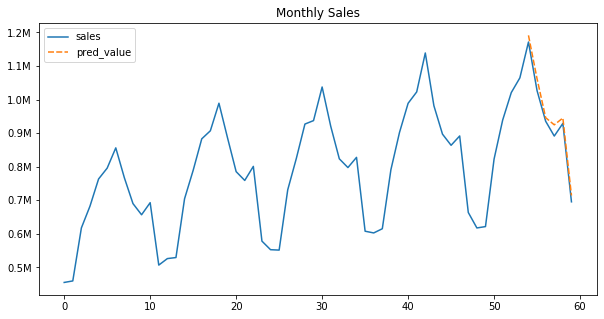

In [39]:
fig, ax = plt.subplots(1,1,figsize=(10,5))
list_data = [df_sales_pred.loc[:, "sales"], df_sales_pred.loc[:, "pred_value"]]
sns.lineplot(data=list_data, ax=ax)

# format x-axis in Millions
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: '{:,.1f}'.format(x/1000000) + 'M'))
ax.set(title='Monthly Sales')

[Text(0.5, 1, 'Monthly Sales')]

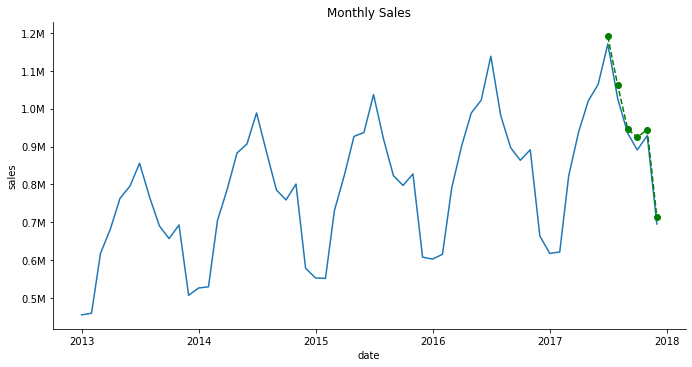

In [41]:
# plot actual monthly sales
g = sns.relplot(x='date', y='sales', kind='line', aspect=2, data=df_sales_pred)
# plot predicted sales for last 6 months
plt.plot(df_sales_pred['date'], df_sales_pred['pred_value'], 'go--')

# format x-axis in Millions
g.ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: '{:,.1f}'.format(x/1000000) + 'M'))
g.ax.set(title='Monthly Sales')

Looks pretty good for a simple model.

One improvement we can do for this model is to add holidays, breaks, and other seasonal effects. They can be simply added as a new feature.

By using this model, we have our baseline sales predictions. But how we can predict the effect of a promotion on sales? We will look into it in Part 7.

### Plotly graphs

In [42]:
#import plotly for visualization
import plotly.graph_objects as go
import plotly.figure_factory as ff

ModuleNotFoundError: No module named 'plotly'

In [ ]:
#plot monthly sales
plot_data = [
    go.Scatter(
        x=df_M_sales['date'],
        y=df_M_sales['sales'],
    )
]

plot_layout = go.Layout(
        title='Montly Sales'
    )
fig = go.Figure(data=plot_data, layout=plot_layout)
fig.show()